# Membangun Chatbot Question-Answering dengan RNN dan LSTM
Proyek ini bertujuan untuk membangun model Question-Answering (QA) sederhana menggunakan arsitektur Encoder-Decoder. Model akan dilatih pada dataset SQuAD versi Indonesia untuk dapat menjawab pertanyaan berdasarkan konteks (paragraf) yang diberikan. Dua arsitektur dicoba dalam eksperimen ini: SimpleRNN dan LSTM.

## Import library awal

In [1]:
import pandas as pd
import json

## Load dataset dan EDA

In [2]:
# Ganti dengan path file Anda
file_path = 'train-SQuAD-id.json' 

# Membuka dan memuat data dari file JSON
with open(file_path, 'r', encoding='utf-8') as f:
    squad_data = json.load(f)

In [3]:
# List untuk menampung data yang sudah diekstrak
processed_data = []

In [4]:
# Looping melalui struktur JSON yang kompleks
print("Memproses file JSON...")
for group in squad_data['data']:
    for paragraph in group['paragraphs']:
        konteks = paragraph['context']
        for qa in paragraph['qas']:
            pertanyaan = qa['question']
            
            # Hanya mengambil data yang bisa dijawab (bukan is_impossible)
            if not qa['is_impossible']:
                # Ambil jawaban pertama (karena bisa ada beberapa)
                if len(qa['answers']) > 0:
                    jawaban = qa['answers'][0]['text']
                    processed_data.append({
                        'konteks': konteks,
                        'pertanyaan': pertanyaan,
                        'jawaban': jawaban
                    })

Memproses file JSON...


In [5]:
# Mengubah list menjadi DataFrame Pandas
df_squad = pd.DataFrame(processed_data)
print("✅ Proses selesai!")

✅ Proses selesai!


## Import libary lanjutan untuk pre-processing dan model

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, SimpleRNN, Dense, Concatenate
from sklearn.model_selection import train_test_split

Jumlah data: 76444

Cek data kosong:
 konteks       0
pertanyaan    0
jawaban       0
dtype: int64

Contoh data:
                                                  konteks  \
26728  Sebagai akibat dari Perang Saudara Libya, Pers...   
13713  Awal 1990-an menandai pelunakan R&B perkotaan ...   
5007   Sementara dia mencari pencerahan, Gautama meng...   

                                              pertanyaan  \
26728  Siapa nama pemimpin Libya yang ditentang oleh ...   
13713  Dekade apa yang menunjukkan munculnya rock alt...   
5007        Apakah "empat pikiran yang tak terukur" itu?   

                                                 jawaban  
26728                                    Muammar Gaddafi  
13713                                            1990-an  
5007   cinta, welas asih, kegembiraan, dan keseimbang...  

Panjang rata-rata teks:
len_konteks       107.391228
len_pertanyaan      8.842996
len_jawaban         2.903210
dtype: float64


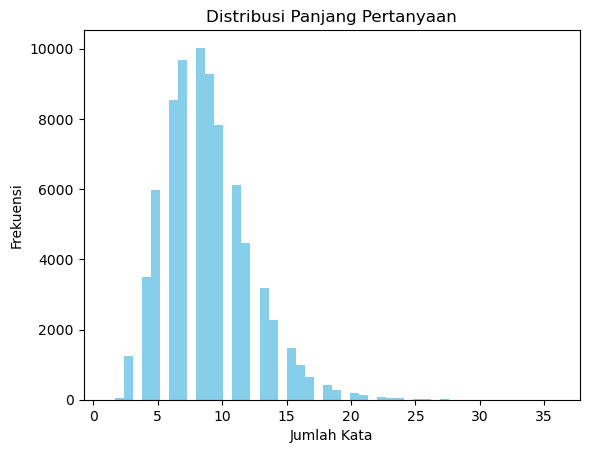


Kata paling sering: [('yang', 44634), ('Apa', 16744), ('apa', 14365), ('di', 14314), ('untuk', 8407), ('dari', 7454), ('Berapa', 6907), ('tahun', 6608), ('pada', 6458), ('dan', 6436)]


In [7]:
print("Jumlah data:", len(df_squad))
print("\nCek data kosong:\n", df_squad.isnull().sum())
print("\nContoh data:\n", df_squad.sample(3))

# Panjang rata-rata pertanyaan, konteks, jawaban
df_squad["len_pertanyaan"] = df_squad["pertanyaan"].apply(lambda x: len(x.split()))
df_squad["len_konteks"] = df_squad["konteks"].apply(lambda x: len(x.split()))
df_squad["len_jawaban"] = df_squad["jawaban"].apply(lambda x: len(x.split()))

print("\nPanjang rata-rata teks:")
print(df_squad[["len_konteks", "len_pertanyaan", "len_jawaban"]].mean())

# Distribusi panjang pertanyaan
import matplotlib.pyplot as plt
plt.hist(df_squad["len_pertanyaan"], bins=50, color='skyblue')
plt.title("Distribusi Panjang Pertanyaan")
plt.xlabel("Jumlah Kata")
plt.ylabel("Frekuensi")
plt.show()

# 10 kata yang paling sering muncul di pertanyaan
from collections import Counter
all_words = " ".join(df_squad["pertanyaan"]).split()
common = Counter(all_words).most_common(10)
print("\nKata paling sering:", common)

## Pre-processing data

In [8]:
# Ambil sample data (gunakan df_squad yang sudah ada)
df_sample = df_squad.head(5000).copy()  # Ambil 5000 data untuk training

# Pisahkan data
contexts = df_sample['konteks'].tolist()
questions = df_sample['pertanyaan'].tolist()
answers = df_sample['jawaban'].tolist()

In [9]:
# Buat tokenizer untuk semua teks
all_texts = contexts + questions + answers

tokenizer = Tokenizer(num_words=20000, oov_token='<OOV>', lower=True)
tokenizer.fit_on_texts(all_texts)

vocab_size = len(tokenizer.word_index) + 1
print(f"Ukuran vocabulary: {vocab_size}")

Ukuran vocabulary: 11929


In [10]:
# Convert ke sequences
context_seq = tokenizer.texts_to_sequences(contexts)
question_seq = tokenizer.texts_to_sequences(questions)
answer_seq = tokenizer.texts_to_sequences(answers)

# Tentukan max length
max_context_len = 150
max_question_len = 30
max_answer_len = 20

# Padding sequences
context_padded = pad_sequences(context_seq, maxlen=max_context_len, padding='post', truncating='post')
question_padded = pad_sequences(question_seq, maxlen=max_question_len, padding='post', truncating='post')
answer_padded = pad_sequences(answer_seq, maxlen=max_answer_len, padding='post', truncating='post')

print("✅ Tokenisasi dan padding selesai")
print(f"Shape context: {context_padded.shape}")
print(f"Shape question: {question_padded.shape}")
print(f"Shape answer: {context_padded.shape}")

✅ Tokenisasi dan padding selesai
Shape context: (5000, 150)
Shape question: (5000, 30)
Shape answer: (5000, 150)


In [11]:
# Target adalah answer sequence itu sendiri
decoder_target_data = answer_padded

print("✅ Target data siap")
print(f"Shape decoder target: {decoder_target_data.shape}")

✅ Target data siap
Shape decoder target: (5000, 20)


In [12]:
# Split data
(context_train, context_val, 
 question_train, question_val, 
 answer_train, answer_val,
 target_train, target_val) = train_test_split(
    context_padded, question_padded, answer_padded, decoder_target_data,
    test_size=0.2, random_state=42
)

print(f"Data training: {len(context_train)}")
print(f"Data validation: {len(context_val)}")

Data training: 4000
Data validation: 1000


## Pembuatan Model SimpleRNN

In [13]:
# Hyperparameters
embedding_dim = 128
rnn_units = 256

# === ENCODER ===
# Input untuk context dan question
context_input = Input(shape=(max_context_len,), name='context_input')
question_input = Input(shape=(max_question_len,), name='question_input')

# Shared embedding layer
embedding_layer = Embedding(vocab_size, embedding_dim, mask_zero=True)

# Encode context
context_embedded = embedding_layer(context_input)
context_rnn = SimpleRNN(rnn_units, return_state=True, name='context_rnn')
_, context_state = context_rnn(context_embedded)

# Encode question
question_embedded = embedding_layer(question_input)
question_rnn = SimpleRNN(rnn_units, return_state=True, name='question_rnn')
_, question_state = question_rnn(question_embedded)

# Gabungkan context dan question state
encoder_state = Concatenate()([context_state, question_state])
encoder_state = Dense(rnn_units, activation='tanh', name='combined_state')(encoder_state)

# === DECODER ===
# Input untuk answer (decoder)
decoder_input = Input(shape=(max_answer_len,), name='decoder_input')
decoder_embedded = embedding_layer(decoder_input)

# Decoder RNN
decoder_rnn = SimpleRNN(rnn_units, return_sequences=True, return_state=True, name='decoder_rnn')
decoder_output, _ = decoder_rnn(decoder_embedded, initial_state=encoder_state)

# Output layer
decoder_dense = Dense(vocab_size, activation='softmax', name='output_layer')
decoder_outputs = decoder_dense(decoder_output)

# Model lengkap
model = Model(
    inputs=[context_input, question_input, decoder_input],
    outputs=decoder_outputs
)

print("✅ Model RNN murni berhasil dibuat!")
model.summary()

✅ Model RNN murni berhasil dibuat!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)    │ (None, 20)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ context_input (InputLayer)    │ (None, 150)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ question_input (InputLayer)   │ (None, 30)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 20, 128)           │       1,526,912 │ context_input[0][0],       │
│                               │                           │                 │ question_input[0][0],      │
│                               │                           │                 │ decoder_input[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal (NotEqual)          │ (None, 150)               │               0 │ context_input[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal_1 (NotEqual)        │ (None, 30)                │               0 │ question_input[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ context_rnn (SimpleRNN)       │ [(None, 256), (None,      │          98,560 │ embedding[0][0],           │
│                               │ 256)]                     │                 │ not_equal[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ question_rnn (SimpleRNN)      │ [(None, 256), (None,      │          98,560 │ embedding[1][0],           │
│                               │ 256)]                     │                 │ not_equal_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 512)               │               0 │ context_rnn[0][1],         │
│                               │                           │                 │ question_rnn[0][1]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ combined_state (Dense)        │ (None, 256)               │         131,328 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ decoder_rnn (SimpleRNN)       │ [(None, 20, 256), (None,  │          98,560 │ embedding[2][0],           │
│                               │ 256)]                     │                 │ combined_state[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_layer (Dense)          │ (None, 20, 11929)         │       3,065,753 │ decoder_rnn[0][0]          │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 5,019,673 (19.15 MB)

 Trainable params: 5,019,673 (19.15 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Gunakan sparse_categorical_crossentropy untuk hemat memory
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Sparse version!
    metrics=['accuracy']
)

print("✅ Model berhasil di-compile")

✅ Model berhasil di-compile


## Training model SimpleRNN sebanyak 50 epoch dengan earlystop

In [15]:
# Callback untuk early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Training
print("\n🚀 Memulai training...")
history = model.fit(
    [context_train, question_train, answer_train],
    target_train,
    batch_size=32,
    epochs=50,
    validation_data=(
        [context_val, question_val, answer_val],
        target_val
    ),
    callbacks=[early_stop],
    verbose=1
)

print("✅ Training selesai!")


🚀 Memulai training...
Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 45s 339ms/step - accuracy: 0.0031 - loss: 8.5485 - val_accuracy: 0.0040 - val_loss: 7.9827
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 329ms/step - accuracy: 0.0046 - loss: 6.9828 - val_accuracy: 0.0065 - val_loss: 7.4736
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 35s 277ms/step - accuracy: 0.0074 - loss: 6.2970 - val_accuracy: 0.0108 - val_loss: 7.4247
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 241ms/step - accuracy: 0.0121 - loss: 5.7854 - val_accuracy: 0.0130 - val_loss: 7.0386
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 236ms/step - accuracy: 0.0208 - loss: 5.1282 - val_accuracy: 0.0223 - val_loss: 6.6046
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 236ms/step - accuracy: 0.0356 - loss: 4.3279 - val_accuracy: 0.0356 - val_loss: 6.0572
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 236ms/step - accuracy: 0.0530 - loss: 3.5301 - val_accuracy: 0.0471 - val_loss: 5.5934
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 237ms/step - acc

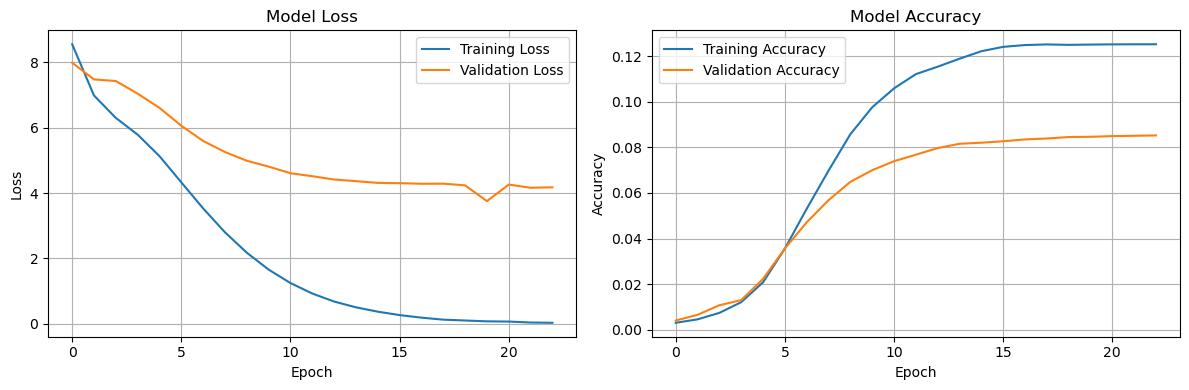

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Hasil Training
Model dilatih selama 50 epoch dengan EarlyStopping. Training berhenti pada epoch ke-23.
* Hasil: Akurasi training stagnan di 0.1252 dan tidak menunjukkan kemajuan.
* Analisis: Model gagal belajar (underfitting), kemungkinan besar karena vanishing gradient problem pada SimpleRNN yang kesulitan menangani sekuens panjang.

In [17]:
# Encoder inference model
encoder_model = Model(
    inputs=[context_input, question_input],
    outputs=encoder_state
)

# Decoder inference model
decoder_state_input = Input(shape=(rnn_units,))
decoder_embedded_inf = embedding_layer(decoder_input)
decoder_output_inf, decoder_state_inf = decoder_rnn(
    decoder_embedded_inf,
    initial_state=decoder_state_input
)
decoder_output_inf = decoder_dense(decoder_output_inf)

decoder_model = Model(
    inputs=[decoder_input, decoder_state_input],
    outputs=[decoder_output_inf, decoder_state_inf]
)

print("✅ Model inference berhasil dibuat!")

✅ Model inference berhasil dibuat!


In [18]:
def predict_answer(context, question, max_length=20):
    """
    Prediksi jawaban berdasarkan context dan question
    """
    # Tokenize input
    context_seq = tokenizer.texts_to_sequences([context])
    question_seq = tokenizer.texts_to_sequences([question])
    
    # Padding
    context_pad = pad_sequences(context_seq, maxlen=max_context_len, padding='post')
    question_pad = pad_sequences(question_seq, maxlen=max_question_len, padding='post')
    
    # Get encoder state
    state = encoder_model.predict([context_pad, question_pad], verbose=0)
    
    # Start dengan token kosong (index 0)
    target_seq = np.zeros((1, 1))
    
    # Decode sequence
    decoded_sentence = []
    
    for _ in range(max_length):
        output, state = decoder_model.predict([target_seq, state], verbose=0)
        
        # Sample token
        sampled_token_index = np.argmax(output[0, 0, :])
        
        # Stop jika padding atau tidak ada kata
        if sampled_token_index == 0:
            break
            
        # Convert index ke kata
        sampled_word = None
        for word, index in tokenizer.word_index.items():
            if index == sampled_token_index:
                sampled_word = word
                break
        
        if sampled_word:
            decoded_sentence.append(sampled_word)
        
        # Update target sequence
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
    
    return ' '.join(decoded_sentence)

print("✅ Fungsi prediksi siap digunakan!")

✅ Fungsi prediksi siap digunakan!


In [19]:
test_idx = 0
test_context = contexts[test_idx]
test_question = questions[test_idx]
true_answer = answers[test_idx]

print("=" * 60)
print("📝 TEST PREDIKSI")
print("=" * 60)
print(f"\nKonteks:\n{test_context[:200]}...\n")
print(f"Pertanyaan: {test_question}")
print(f"\nJawaban Asli: {true_answer}")

predicted_answer = predict_answer(test_context, test_question)
print(f"Jawaban Prediksi: {predicted_answer}")
print("=" * 60)

📝 TEST PREDIKSI

Konteks:
Beyoncé Giselle Knowles-Carter (/ biːˈjɒnseɪ / bee-YON-say) (lahir 4 September 1981) adalah seorang penyanyi, penulis lagu, produser rekaman dan aktris Amerika. Dilahirkan dan dibesarkan di Houston, T...

Pertanyaan: Kapan Beyonce mulai populer?

Jawaban Asli: pada akhir 1990-an
Jawaban Prediksi: tanggal alexandra adichie panjang synthesizer mendengung cable benefit benefit seorang seorang seorang seorang seorang seorang seorang seorang seorang seorang seorang


In [20]:
def tanya_jawab(context, question):
    """
    Fungsi helper untuk tanya jawab interaktif
    """
    print("\n" + "="*60)
    print("🤖 CHATBOT QA")
    print("="*60)
    print(f"\n📄 Konteks:\n{context[:300]}...\n")
    print(f"❓ Pertanyaan: {question}\n")
    
    answer = predict_answer(context, question)
    print(f"💬 Jawaban: {answer}")
    print("="*60)
    
    return answer

# Contoh penggunaan
sample_context = contexts[5]
sample_question = questions[5]

tanya_jawab(sample_context, sample_question)


🤖 CHATBOT QA

📄 Konteks:
Beyoncé Giselle Knowles-Carter (/ biːˈjɒnseɪ / bee-YON-say) (lahir 4 September 1981) adalah seorang penyanyi, penulis lagu, produser rekaman dan aktris Amerika. Dilahirkan dan dibesarkan di Houston, Texas, ia tampil di berbagai kompetisi menyanyi dan menari sebagai seorang anak, dan mulai terkenal p...

❓ Pertanyaan: Dalam grup R&B apa dia menjadi penyanyi utama?

💬 Jawaban: tanggal alexandra adichie panjang synthesizer mendengung cable benefit benefit seorang seorang seorang seorang seorang seorang seorang seorang seorang seorang seorang


'tanggal alexandra adichie panjang synthesizer mendengung cable benefit benefit seorang seorang seorang seorang seorang seorang seorang seorang seorang seorang seorang'

## Buat Model LSTM

In [21]:
from tensorflow.keras.layers import LSTM

In [22]:
# Hyperparameters (bisa disamakan dengan sebelumnya)
embedding_dim = 128
rnn_units = 256 # Kita akan menggunakan LSTM units

# === ENCODER (LSTM) ===
# Input untuk context dan question
context_input = Input(shape=(max_context_len,), name='context_input_lstm')
question_input = Input(shape=(max_question_len,), name='question_input_lstm')

# Shared embedding layer (bisa menggunakan yang sudah ada atau membuat baru)
# Untuk konsistensi, kita definisikan ulang di sini
embedding_layer = Embedding(vocab_size, embedding_dim, mask_zero=True)

# Encode context
context_embedded = embedding_layer(context_input)
# Ganti SimpleRNN dengan LSTM
context_lstm = LSTM(rnn_units, return_state=True, name='context_lstm')
# LSTM mengembalikan 3 state: output, hidden state, cell state
_, context_state_h, context_state_c = context_lstm(context_embedded)
context_states = [context_state_h, context_state_c]

# Encode question
question_embedded = embedding_layer(question_input)
# Ganti SimpleRNN dengan LSTM
question_lstm = LSTM(rnn_units, return_state=True, name='question_lstm')
_, question_state_h, question_state_c = question_lstm(question_embedded)
question_states = [question_state_h, question_state_c]

# Gabungkan state dari context dan question
# Kita akan menggabungkan hidden state dan cell state secara terpisah
encoder_state_h = Concatenate()([context_state_h, question_state_h])
encoder_state_c = Concatenate()([context_state_c, question_state_c])

# Reduksi dimensi gabungan state agar sesuai dengan decoder units
combined_state_h = Dense(rnn_units, activation='tanh', name='combined_state_h')(encoder_state_h)
combined_state_c = Dense(rnn_units, activation='tanh', name='combined_state_c')(encoder_state_c)
encoder_states = [combined_state_h, combined_state_c]

# === DECODER (LSTM) ===
# Input untuk answer (decoder)
decoder_input = Input(shape=(max_answer_len,), name='decoder_input_lstm')
decoder_embedded = embedding_layer(decoder_input)

# Decoder LSTM
# Inisialisasi state decoder dengan state dari encoder
decoder_lstm = LSTM(rnn_units, return_sequences=True, return_state=True, name='decoder_lstm')
decoder_output, _, _ = decoder_lstm(decoder_embedded, initial_state=encoder_states)

# Output layer (sama seperti sebelumnya)
decoder_dense = Dense(vocab_size, activation='softmax', name='output_layer_lstm')
decoder_outputs = decoder_dense(decoder_output)

# Model LSTM lengkap
model_lstm = Model(
    inputs=[context_input, question_input, decoder_input],
    outputs=decoder_outputs
)

print("✅ Model LSTM berhasil dibuat!")
model_lstm.summary()

✅ Model LSTM berhasil dibuat!


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ decoder_input_lstm            │ (None, 20)                │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ context_input_lstm            │ (None, 150)               │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ question_input_lstm           │ (None, 30)                │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_1 (Embedding)       │ (None, 20, 128)           │       1,526,912 │ context_input_lstm[0][0],  │
│                               │                           │                 │ question_input_lstm[0][0], │
│                               │                           │                 │ decoder_input_lstm[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal_4 (NotEqual)        │ (None, 150)               │               0 │ context_input_lstm[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal_5 (NotEqual)        │ (None, 30)                │               0 │ question_input_lstm[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ context_lstm (LSTM)           │ [(None, 256), (None,      │         394,240 │ embedding_1[0][0],         │
│                               │ 256), (None, 256)]        │                 │ not_equal_4[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ question_lstm (LSTM)          │ [(None, 256), (None,      │         394,240 │ embedding_1[1][0],         │
│                               │ 256), (None, 256)]        │                 │ not_equal_5[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 512)               │               0 │ context_lstm[0][1],        │
│                               │                           │                 │ question_lstm[0][1]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_2 (Concatenate)   │ (None, 512)               │               0 │ context_lstm[0][2],        │
│                               │                           │                 │ question_lstm[0][2]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ combined_state_h (Dense)      │ (None, 256)               │         131,328 │ concatenate_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ combined_state_c (Dense)      │ (None, 256)               │         131,328 │ concatenate_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ decoder_lstm (LSTM)           │ [(None, 20, 256), (None,  │         394,24

 Total params: 6,038,041 (23.03 MB)

 Trainable params: 6,038,041 (23.03 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Compile model LSTM
model_lstm.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Model LSTM berhasil di-compile")

# Callback early stopping (bisa digunakan kembali)
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

✅ Model LSTM berhasil di-compile


## Training model LSTM dengan 50 epoch juga dengan earlystop

In [24]:
# Training model LSTM
print("\n🚀 Memulai training model LSTM...")
history_lstm = model_lstm.fit(
    [context_train, question_train, answer_train],
    target_train,
    batch_size=32,
    epochs=50, # Anda bisa sesuaikan jumlah epoch
    validation_data=(
        [context_val, question_val, answer_val],
        target_val
    ),
    callbacks=[early_stop],
    verbose=1
)

print("✅ Training LSTM selesai!")


🚀 Memulai training model LSTM...
Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 52s 391ms/step - accuracy: 0.0032 - loss: 8.4515 - val_accuracy: 0.0037 - val_loss: 7.7686
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 47s 376ms/step - accuracy: 0.0040 - loss: 7.0293 - val_accuracy: 0.0057 - val_loss: 7.4906
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 45s 362ms/step - accuracy: 0.0064 - loss: 6.4436 - val_accuracy: 0.0091 - val_loss: 7.3306
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 45s 361ms/step - accuracy: 0.0089 - loss: 5.9802 - val_accuracy: 0.0113 - val_loss: 7.3275
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 44s 352ms/step - accuracy: 0.0109 - loss: 5.5954 - val_accuracy: 0.0125 - val_loss: 7.3311
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 327ms/step - accuracy: 0.0136 - loss: 5.2625 - val_accuracy: 0.0147 - val_loss: 7.2516
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 328ms/step - accuracy: 0.0171 - loss: 4.9461 - val_accuracy: 0.0163 - val_loss: 7.2215
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 331ms

## Hasil Training
Model dilatih selama 50 epoch dengan EarlyStopping. Training berhenti pada epoch ke-33.

* Hasil: Tidak seperti SimpleRNN, metrik accuracy dan loss pada LSTM menunjukkan progres belajar yang jelas.

* Training loss turun dari 8.45 ke 0.04.

* Validation loss turun hingga 4.77 lalu stagnan.

* Analisis: Model berhasil belajar, namun setelah sekitar epoch 25-30, model mulai overfitting.

In [25]:
# === Encoder Inference Model ===
# Model ini akan mengambil konteks dan pertanyaan, lalu menghasilkan state LSTM.
encoder_model_lstm = Model(
    inputs=[context_input, question_input],
    outputs=encoder_states  # Outputnya adalah [hidden_state, cell_state]
)

# === Decoder Inference Model ===
# Kita perlu mendefinisikan input state untuk decoder secara terpisah
decoder_state_input_h = Input(shape=(rnn_units,), name='decoder_state_input_h')
decoder_state_input_c = Input(shape=(rnn_units,), name='decoder_state_input_c')
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Input untuk token jawaban (satu per satu)
decoder_input_single_step = Input(shape=(1,), name='decoder_input_single_step')
decoder_embedded_single_step = embedding_layer(decoder_input_single_step)

# Panggil layer LSTM yang sudah dilatih dengan state input baru
# Kita akan mendapatkan output dan state baru
decoder_output_inf, state_h_inf, state_c_inf = decoder_lstm(
    decoder_embedded_single_step, initial_state=decoder_states_inputs
)
decoder_states_inf = [state_h_inf, state_c_inf]

# Dense layer untuk prediksi kata berikutnya
decoder_output_inf = decoder_dense(decoder_output_inf)

# Model decoder final untuk inference
decoder_model_lstm = Model(
    inputs=[decoder_input_single_step] + decoder_states_inputs,
    outputs=[decoder_output_inf] + decoder_states_inf
)

print("✅ Model inference LSTM berhasil dibuat!")

✅ Model inference LSTM berhasil dibuat!


In [26]:
def predict_answer_lstm(context, question, max_length=20):
    """
    Prediksi jawaban menggunakan model inference LSTM.
    """
    # Tokenize dan padding input
    context_seq = tokenizer.texts_to_sequences([context])
    question_seq = tokenizer.texts_to_sequences([question])
    context_pad = pad_sequences(context_seq, maxlen=max_context_len, padding='post')
    question_pad = pad_sequences(question_seq, maxlen=max_question_len, padding='post')

    # 1. Dapatkan initial state dari encoder
    states_value = encoder_model_lstm.predict([context_pad, question_pad], verbose=0)

    # 2. Siapkan input pertama untuk decoder (token kosong, biasanya index 0)
    target_seq = np.zeros((1, 1))

    # 3. Proses decoding langkah-demi-langkah
    decoded_sentence = []
    for _ in range(max_length):
        # Prediksi token berikutnya dan dapatkan state baru
        output_tokens, h, c = decoder_model_lstm.predict(
            [target_seq] + states_value, verbose=0
        )

        # Ambil token dengan probabilitas tertinggi
        sampled_token_index = np.argmax(output_tokens[0, -1, :])

        # Hentikan jika token adalah padding (index 0)
        if sampled_token_index == 0:
            break

        # Ubah index menjadi kata
        sampled_word = tokenizer.index_word.get(sampled_token_index, '')
        decoded_sentence.append(sampled_word)

        # Update input untuk langkah berikutnya
        target_seq = np.array([[sampled_token_index]])
        states_value = [h, c]

    return ' '.join(decoded_sentence)

print("✅ Fungsi prediksi LSTM siap digunakan!")

✅ Fungsi prediksi LSTM siap digunakan!


In [27]:
# Pilih data uji (misalnya, data pertama dari dataset)
test_idx = 0
test_context = contexts[test_idx]
test_question = questions[test_idx]
true_answer = answers[test_idx]

print("=" * 60)
print("📝 TEST PREDIKSI (MODEL LSTM)")
print("=" * 60)
print(f"\nKonteks:\n{test_context[:200]}...\\n")
print(f"Pertanyaan: {test_question}")
print(f"\nJawaban Asli: {true_answer}")

# Panggil fungsi prediksi LSTM
predicted_answer_lstm = predict_answer_lstm(test_context, test_question)
print(f"Jawaban Prediksi (LSTM): {predicted_answer_lstm}")
print("=" * 60)

📝 TEST PREDIKSI (MODEL LSTM)

Konteks:
Beyoncé Giselle Knowles-Carter (/ biːˈjɒnseɪ / bee-YON-say) (lahir 4 September 1981) adalah seorang penyanyi, penulis lagu, produser rekaman dan aktris Amerika. Dilahirkan dan dibesarkan di Houston, T...\n
Pertanyaan: Kapan Beyonce mulai populer?

Jawaban Asli: pada akhir 1990-an
Jawaban Prediksi (LSTM): le corbusier levinson levinson jatuh jatuh jatuh jatuh jatuh jatuh it it it elektronik elektronik elektronik elektronik elektronik elektronik elektronik


## 5. Perbandingan Model: SimpleRNN vs. LSTM

Tabel berikut merangkum perbandingan langsung antara kedua model berdasarkan hasil eksperimen pada 5.000 sampel data.

| Fitur | SimpleRNN | LSTM |
|---|---|---|
| **Unit Rekuren** | `SimpleRNN` | `LSTM` (dengan *memory gates*) |
| **Jumlah Parameter** | ~5,0 juta | ~6,0 juta (lebih kompleks) |
| **Waktu Training** | Lebih cepat (~30-40 detik/epoch) | Lebih lambat (~40-50 detik/epoch) |
| **Hasil Training** | Stagnan, akurasi tidak meningkat secara signifikan. | Menunjukkan progres belajar yang jelas (loss turun, akurasi naik). |
| **Permasalahan Utama**| Gagal belajar (kemungkinan **vanishing gradient**). | **Overfitting** setelah ~25 epoch karena data terlalu sedikit. |
| **Potensi** | Rendah untuk tugas kompleks ini. | Tinggi, namun membutuhkan lebih banyak data untuk generalisasi. |

## Analisis dan Kesimpulan
Eksperimen ini menunjukkan beberapa poin penting:

* SimpleRNN Gagal: Model SimpleRNN tidak cocok untuk tugas QA yang kompleks ini karena keterbatasannya dalam menangani dependensi jangka panjang.

* LSTM Belajar, Tapi Overfitting: Model LSTM menunjukkan kemampuan belajar yang jauh lebih baik. Namun, karena dilatih pada dataset yang sangat terbatas (hanya 4.000 data training), model mulai menghafal data training alih-alih belajar pola umum.

Prediksi dari kedua model menghasilkan teks yang tidak koheren, yang mengonfirmasi bahwa model belum berhasil memahami tugasnya.